In [34]:
import numpy as np
from numpy import radians, pi
from lib.cartpoles import CartPoleSystem, CartPolesEnv
from lib.colors import Colors
from lib.controllers import LQR
import time
from matplotlib import pyplot as plt
from scipy.io import savemat

In [35]:
dt = 0.002
g = 9.81

system_noise = 0 * np.diag(np.ones(4))

system = CartPoleSystem(
    (0.0, 0.5, 0.005, -0.8, 0.8, Colors.red),
    (0.2, 8.7e-5, 8.7e-5, 0.02, 0.05, -24.0, 24.0, Colors.black),
    [
        (0, 0.5, 0.2, 0.005, Colors.green),
    ],
    g,
    "rk4",
    "nonlinear",
    system_noise
)

env = CartPolesEnv(system, dt, g)
env.observation_space.shape

(4, 1)

In [36]:
linearization_x0 = np.vstack([0, 0, 0, 0])
linearization_u0 = np.vstack([0])

A, B = system.linearize(linearization_x0, linearization_u0)
savemat("AB.mat", {"A": A, "B": B})

C = np.diag([1, 1, 1, 1])
D = np.zeros((4, 1))

ct_dt = dt

sys = LQR(A, B, C, D, dt=ct_dt)

Q = np.diag([1, 1, 1, 1])
R = np.diag([0.1])

sys.calculate_K_lqr(Q, R)
sys.calculate_K_r()

In [37]:
x0 = np.vstack([-0.4, 0, 0, -radians(45)])
obs, _ = env.reset(x0)

r = np.array(
    [0.1, 0, 0, 0]
)

end_time = 10
N = int(end_time/dt)

states = {
    "u": [],
    "i": [],
}

for i in range(N):
    u = sys.feedforward_d(obs, r)
    max_Ia = 10
    max_Va_from_Ia = system.Ra * max_Ia + system.K*obs[1]/system.r
    min_Va_from_Ia = -max_Va_from_Ia

    if u[0] > min(system.max_Va, max_Va_from_Ia):
        u[0] = min(system.max_Va, max_Va_from_Ia)
    elif u[0] < max(system.min_Va, min_Va_from_Ia):
        u[0] = max(system.min_Va, min_Va_from_Ia)

    states["u"].append(u[0][0])
    states["i"].append((u[0][0] - system.K*obs[1]/system.r)/system.Ra)

    obs, reward, done, msg, _ = env.step(u)
    env.render()
    # time.sleep(dt)
env.close()

AttributeError: 'NoneType' object has no attribute 'fill'

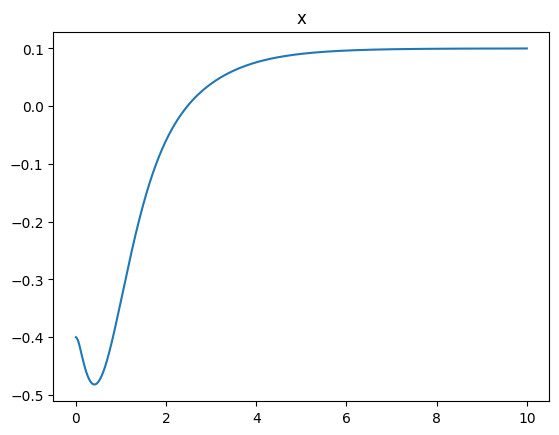

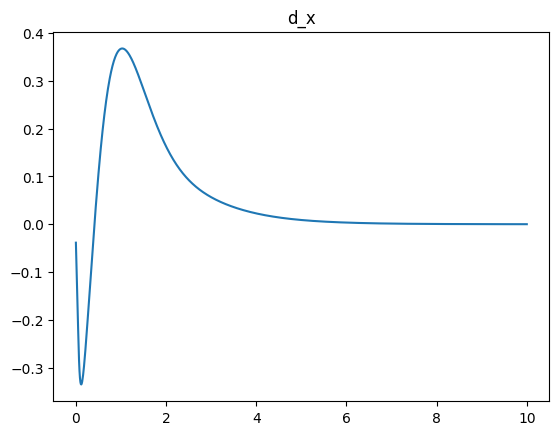

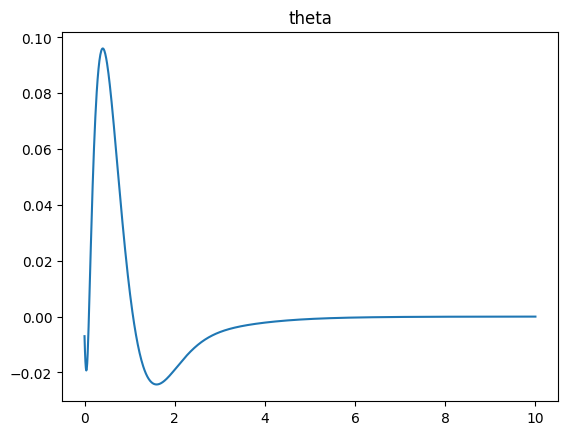

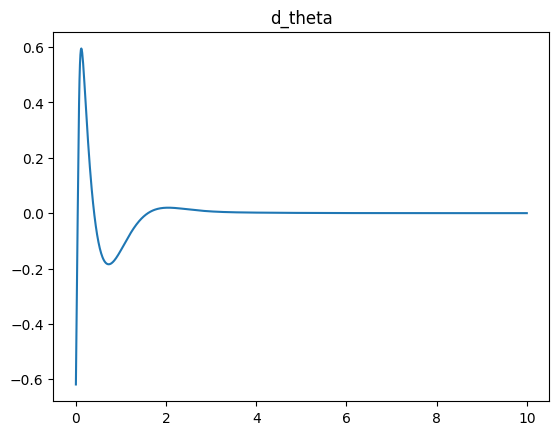

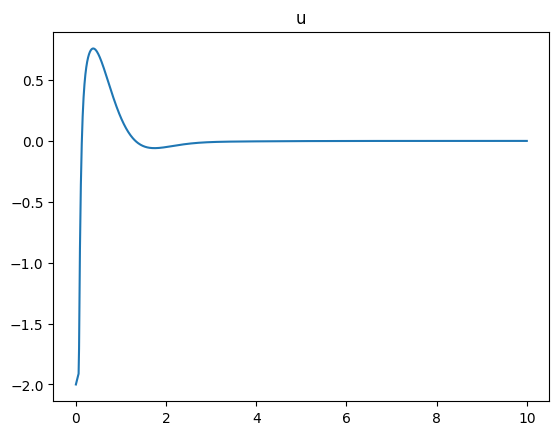

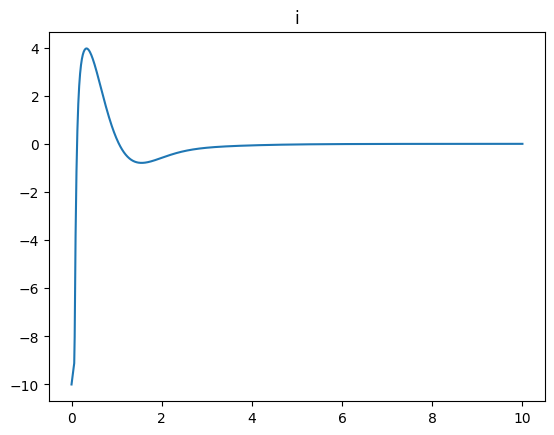

In [ ]:
t = np.linspace(0, end_time, N)
x = env.system.state[0][1:]

plt.plot(t, x)
plt.title("x")
plt.show()

d_x = env.system.state[1][1:]

plt.plot(t, d_x)
plt.title("d_x")
plt.show()

theta = env.system.state[2][1:]

plt.plot(t, theta)
plt.title("theta")
plt.show()

d_theta = env.system.state[3][1:]

plt.plot(t, d_theta)
plt.title("d_theta")
plt.show()

plt.plot(t, states["u"])
plt.title("u")
plt.show()

plt.plot(t, states["i"])
plt.title("i")
plt.show()